In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

2023-04-05 22:57:40.307093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:57:40.555614: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 22:57:40.555645: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 22:57:41.692050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
speakers = os.listdir("training_data_browser")
print("Speakers: ", speakers)

features = np.load("extracted_data/features.npy")
labels = np.load("extracted_data/labels.npy")

Speakers:  ['hannah', 'aiden', 'parker', 'adam']


In [3]:
num_audio_samples = len(features)
num_classes = len(speakers)

# one hot encode our labels
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

# randomize our data each time so we aren't training on the exact same set of data
permutations = np.random.permutation(num_audio_samples)
features = np.array(features)[permutations]
labels_one_hot = np.array(labels_one_hot)[permutations]

# data splits
train_split = 0.8
test_split = 0.1
val_split = 0.1

if train_split + test_split + val_split != 1.0:
  raise ValueError("test, train and validation splits should sum to 1.0 (100%)")

# split our data using numpy split. by giving two indices the data is split three ways:
#  - everything before index 1 will be our training data
#  - everything after index 1 and until index 2 will be our test data
#  - everything after index 2 will be our validation data
features_train, features_test, features_val = np.split(features, [int(num_audio_samples * train_split), int(num_audio_samples * (train_split + test_split))])
labels_train, labels_test, labels_val = np.split(labels_one_hot, [int(num_audio_samples * train_split), int(num_audio_samples * (train_split + test_split))])

Display the amounts of each class to see if we have roughly the same amount of data for each.

In [4]:
_, class_counts = np.unique(labels, return_counts=True)

print(class_counts)
print("Class Counts:")
for i in range(len(speakers)):
  print(f"{speakers[i]} - {class_counts[i]}")
print("\nmin - " + str(np.min(class_counts)))
print("max - " + str(np.max(class_counts)))
print("standard deviation - " + str(np.std(class_counts)))

[1239 1239 1239 1239]
Class Counts:
hannah - 1239
aiden - 1239
parker - 1239
adam - 1239

min - 1239
max - 1239
standard deviation - 0.0


In [5]:
print(features_train.shape)
print(labels_train.shape)

BATCH_SIZE = 32
EPOCHS = 100

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(features_train.shape[1], input_shape=(features_train.shape[1],), activation = "relu"))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(256, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.25))  

model.add(tf.keras.layers.Dense(128, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.25))  

model.add(tf.keras.layers.Dense(64, activation = "relu"))
model.add(tf.keras.layers.Dropout(0.5))  
  

model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()



(3964, 36)
(3964, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                1332      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense_1 (Dense)             (None, 256)               9472      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 


2023-04-05 22:57:43.757572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:57:43.757978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 22:57:43.758082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-05 22:57:43.758169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-05 22:57:43.758256: W tensorflow/c

 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 52,216
Trainable params: 52,216
Non-trainable params: 0
_________________________________________________________________


In [6]:

# Reduce learning rate when a metric has stopped improving
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 patience=4, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)


history = model.fit(features_train, 
                    labels_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(features_val, labels_val),
                    callbacks=[
                      lr_reduction, 
                      estopping
                    ])

Epoch 1/100
124/124 [==============================] - 3s 7ms/step - loss: 1.2977 - accuracy: 0.3829 - val_loss: 0.9403 - val_accuracy: 0.6613 - lr: 0.0010
Epoch 2/100
124/124 [==============================] - 1s 5ms/step - loss: 0.8555 - accuracy: 0.6715 - val_loss: 0.6381 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/100
124/124 [==============================] - 1s 5ms/step - loss: 0.6704 - accuracy: 0.7558 - val_loss: 0.5044 - val_accuracy: 0.8185 - lr: 0.0010
Epoch 4/100
124/124 [==============================] - 1s 5ms/step - loss: 0.5578 - accuracy: 0.8063 - val_loss: 0.4190 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 5/100
124/124 [==============================] - 1s 5ms/step - loss: 0.4789 - accuracy: 0.8398 - val_loss: 0.3694 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 6/100
124/124 [==============================] - 1s 5ms/step - loss: 0.4558 - accuracy: 0.8438 - val_loss: 0.3464 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/100
124/124 [==============================] - 1s 5ms/st

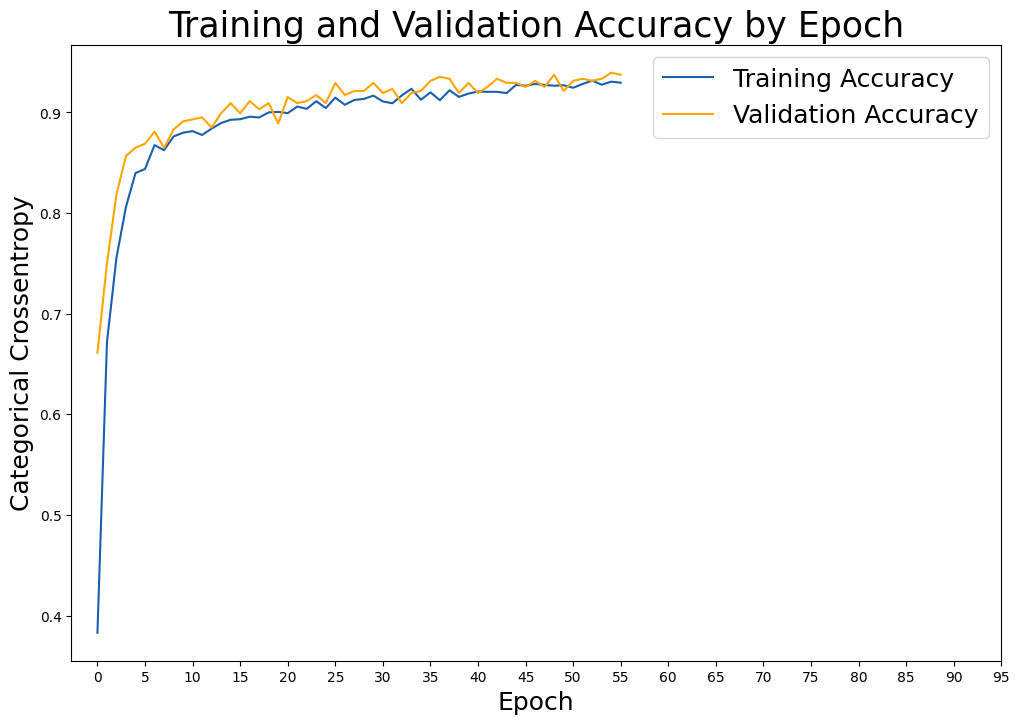

In [7]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,EPOCHS,5), range(0,EPOCHS,5))

plt.legend(fontsize = 18);

In [8]:
# preds = np.argmax(model.predict(features_test), axis=-1)
# print(np.argmax(labels_test, axis=-1))
# print(preds)
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=1)
print('Accuracy : ' + str(score[1]*100) + '%')

16/16 [==============================] - 0s 3ms/step - loss: 0.1539 - accuracy: 0.9476
Accuracy : 94.7580635547638%


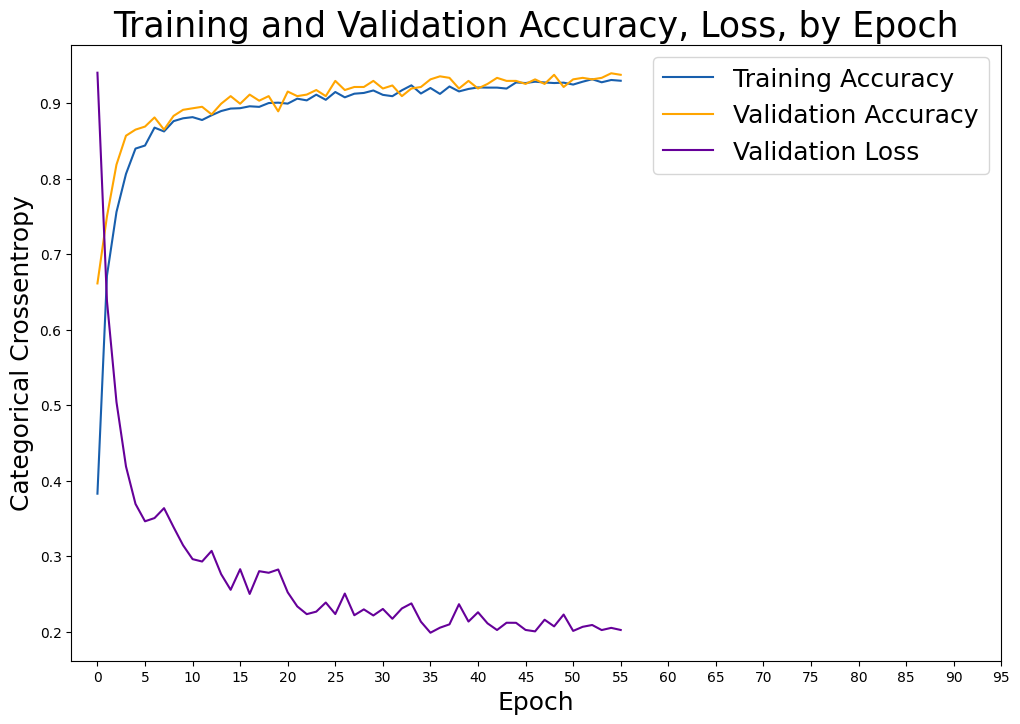

In [9]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.plot(val_loss, label='Validation Loss', color="#660099")

# Set title
plt.title('Training and Validation Accuracy, Loss, by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,EPOCHS,5), range(0,EPOCHS,5))

plt.legend(fontsize = 18);

In [10]:
from datetime import datetime
time = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
model.save(f"../saved_models/{num_classes}_classes-{time}")

INFO:tensorflow:Assets written to: ../saved_models/4_classes-04_05_2023_22_58_25/assets


INFO:tensorflow:Assets written to: ../saved_models/4_classes-04_05_2023_22_58_25/assets
